In [1]:
import numpy as np
import pandas as pd
# import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
import tensorflow.keras.optimizers as optimizers
import os, glob, math
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
import json

# 0. Data Analysis
We first need to check whether the data are consistent, in terms of image dimension.

In [2]:
train_width, train_height = [], []
train_channel = set()
test_width, test_height = [], []
test_channel = set()

In [3]:
for animal in ['dogs', 'cats']:
    animaux = animal[:-1]
    for fname in glob.glob(os.path.join('data', 'train', animal, f'{animaux}*.jpg')):
        im = Image.open(fname)
        w, h = im.size
        train_width.append(w)
        train_height.append(h)
        train_channel.add(im.getbands())
    for fname in glob.glob(os.path.join('data', 'validation', animal, f'{animaux}*.jpg')):
        im = Image.open(fname)
        w, h = im.size
        test_width.append(w)
        test_height.append(h)
        test_channel.add(im.getbands())

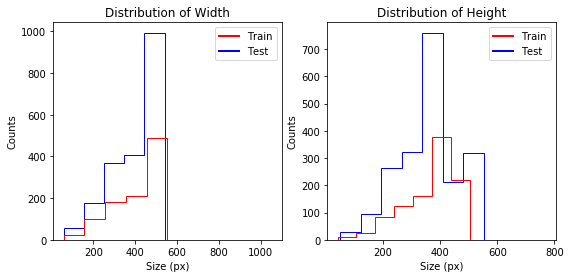

In [4]:
fig = plt.figure(figsize=(9, 4))
from matplotlib.lines import Line2D
custom_lines = [Line2D([1], [1], color='red', lw=2),
                Line2D([1], [1], color='blue', lw=2)]
plt.subplot(1, 2, 1)
plt.title('Distribution of Width')
plt.xlabel('Size (px)')
plt.ylabel('Counts')
plt.hist(train_width, label='trainWidth', color='blue', histtype='step')
plt.hist(test_width, label='testWidth', color='red', histtype='step')
plt.legend(custom_lines, ['Train', 'Test'])
plt.subplot(1, 2, 2)
plt.title('Distribution of Height')
plt.xlabel('Size (px)')
plt.ylabel('Counts')
plt.hist(train_height, label='trainHeight', color='blue', histtype='step')
plt.hist(test_height, label='testHeight', color='red', histtype='step')
plt.legend(custom_lines, ['Train', 'Test'])
plt.show()

In [5]:
df_dist = pd.DataFrame(index=['MedianWidth', 'MedianHeight'])
from fractions import Fraction
df_dist['Train'] = pd.Series({'MedianWidth': np.median(train_width),
                              'MedianHeight': np.median(train_height)})
df_dist['Test'] = pd.Series({'MedianWidth': np.median(test_width),
                              'MedianHeight': np.median(test_height)})
df_dist['Average'] = df_dist.mean(axis=1)
df_dist = df_dist.astype(int)
display (df_dist)

,Train,Test,Average
MedianWidth,442,448,445
MedianHeight,374,374,374


In [6]:
train_channel, test_channel

({('R', 'G', 'B')}, {('R', 'G', 'B')})

# 1. Model Initialisation & Training
We know that the colour channels are concordant between the datasets, i.e. RGB, so we can hardcode it appropriately during data loading. Also, due to the distribution of the dataset dimensions, let's take and rescale to the average of the median values.

In [7]:
BATCH_SIZE = 32
epochs = 5
AVG_MED_WIDTH = 32#int(df_dist.loc['MedianWidth', 'Average']/2)
AVG_MED_HEIGHT = 32#int(df_dist.loc['MedianHeight', 'Average']/2)
print (f'AVG MED WIDTH {AVG_MED_WIDTH}')
print (f'AVG MED HEIGHT {AVG_MED_HEIGHT}')

AVG MED WIDTH 32
AVG MED HEIGHT 32


In [31]:
print ("Getting Training Data")
train_data = ImageDataGenerator(
                rescale=1./255, 
#                 rotation_range=15,
#                 zoom_range=0.2,
                width_shift_range=0.1, 
                height_shift_range=0.1, 
#                 horizontal_flip=True,
#                 vertical_flip=True,
                validation_split=0.05
                )

print ("Subsampling Validation Set")
validation_data = train_data.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('data', 'train'),
                    target_size=(AVG_MED_WIDTH, AVG_MED_HEIGHT),
                    color_mode='rgb',
                    class_mode='binary',
                    classes=['cats', 'dogs'],
                    subset='validation')

print ("Subsampling Training Set")
train_data = train_data.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('data', 'train'),
                    target_size=(AVG_MED_WIDTH, AVG_MED_HEIGHT),
                    color_mode='rgb',
                    class_mode='binary',
                    classes=['cats', 'dogs'],
                    subset='training')

print ("Test Data")
test_data = ImageDataGenerator(
                rescale=1./255
                ).flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('data', 'validation'),
                    target_size=(AVG_MED_WIDTH, AVG_MED_HEIGHT),
                    color_mode='rgb',
                    class_mode='binary',
                    classes=['cats', 'dogs'])

Getting Training Data
Subsampling Validation Set
Found 100 images belonging to 2 classes.
Subsampling Training Set
Found 1900 images belonging to 2 classes.
Test Data
Found 1000 images belonging to 2 classes.


In [32]:
sample_train, label = next(train_data)
num_train_data = train_data.n
num_val_data = validation_data.n
num_test_data = test_data.n

In [33]:
print (num_train_data)

1900


In [34]:
labelName = {0.:'cats', 1.:'dogs'}

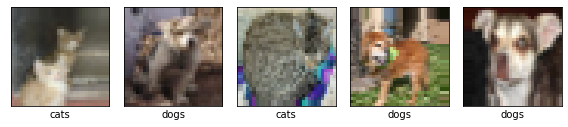

In [35]:
def plotImages(images_arr, label_arr):
    fig, axes = plt.subplots(1, 5, figsize=(8,8))
    axes = axes.flatten()
    for img, dataLabel, ax in zip(images_arr, label_arr, axes):
        ax.imshow(img)
        ax.set_xlabel(labelName[dataLabel])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.tight_layout()
    plt.show()

plotImages(sample_train[:5], label[:5])

In [39]:
model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', #kernel_initializer='he_uniform',
                           input_shape=(AVG_MED_WIDTH, AVG_MED_HEIGHT, 3)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(2, strides=2),
    Dropout(0.2),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(2, strides=1),    
    Dropout(0.2),    
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(2, strides=1),
    Dropout(0.2, seed=111),    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.4),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
    ])
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
model.summary()
now = datetime.strftime(datetime.today(), '%Y%m%d_%H%M')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 15, 15, 128)      

In [40]:
def plotHistory(history):
    fig = plt.figure(figsize=(8, 10))
    plt.subplot(2, 1, 1)
    plt.title('Training Scores')
    plt.plot(history.history['accuracy'], color='blue', label='Accuracy')
    plt.plot(history.history['Precision'], color='red', label='Precision')
    plt.plot(history.history['Recall'], color='green', label='Recall')
    plt.plot(history.history['AUC'], color='magenta', label='AUC')
    plt.plot(history.history['val_accuracy'], '--', color='blue', label='valAccuracy')
    plt.plot(history.history['val_Precision'], '--', color='red', label='valPrecision')
    plt.plot(history.history['val_Recall'], '--', color='green', label='valRecall')
    plt.plot(history.history['val_AUC'], '--', color='magenta', label='valAUC')
    plt.xticks(range(0, epochs))
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.025, 1.01))
    
    plt.subplot(2, 1, 2)
    plt.title('Loss')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.xticks(range(epochs+1))
    plt.plot(history.history['loss'], color='black', label='Loss')
    plt.savefig(f'{now}.png')
    plt.show()
    


In [41]:
history = model.fit(train_data, 
                    steps_per_epoch=math.ceil(num_train_data/BATCH_SIZE), 
                    epochs=epochs,
                    validation_data=validation_data
                    )
plotHistory(history)
with open(f'{now}.json', 'wt') as inj:
    json.dump(history.model.to_json(), inj)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 60 steps, validate for 4 steps
Epoch 1/5
 1/60 [..............................] - ETA: 15s

ValueError: Shapes (None, 2) and (None, 1) are incompatible

In [16]:
print(train_data.__str__)

<method-wrapper '__str__' of DirectoryIterator object at 0x7f735a9d0050>
